<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Тренды-и-сезонность." data-toc-modified-id="Тренды-и-сезонность.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тренды и сезонность.</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-по-дням" data-toc-modified-id="Ресемплирование-по-дням-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ресемплирование по дням</a></span></li><li><span><a href="#Ресемплирование-по-часам" data-toc-modified-id="Ресемплирование-по-часам-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ресемплирование по часам</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Анализ-временных-рядов-и-моделирование-спроса-на-такси" data-toc-modified-id="Анализ-временных-рядов-и-моделирование-спроса-на-такси-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анализ временных рядов и моделирование спроса на такси</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split
)
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    make_scorer
)
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV


In [2]:
def get_data_info(data):
    display(data.sample(5))
    # display(data.info())
    data.info()
    display(data.describe(include='all'))

In [3]:
# Load data
try:
    df = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
    
get_data_info(df)

,num_orders
datetime,
2018-06-08 08:10:00,15
2018-08-02 03:30:00,25
2018-03-04 03:10:00,6
2018-06-26 01:10:00,18
2018-05-13 14:00:00,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
df = df.sort_index()
print(df.index.is_monotonic)
get_data_info(df)

True


,num_orders
datetime,
2018-08-13 17:10:00,18
2018-04-16 02:10:00,27
2018-08-21 23:50:00,35
2018-08-04 00:00:00,32
2018-03-16 06:10:00,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
hour_df = df.resample('1H').sum()

В ходе работы с данными о заказах такси выполнены следующие шаги:

Загрузка данных из CSV файла.
Преобразование столбца 'datetime' в формат datetime и установка его в качестве индекса.
Проверка данных:
Всего строк: 26496
Столбцы: 'datetime' и 'num_orders'
Пропущенных значений нет
Индекс отсортирован по времени и монотонен.
Данные готовы для дальнейшего анализа.








## Анализ

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


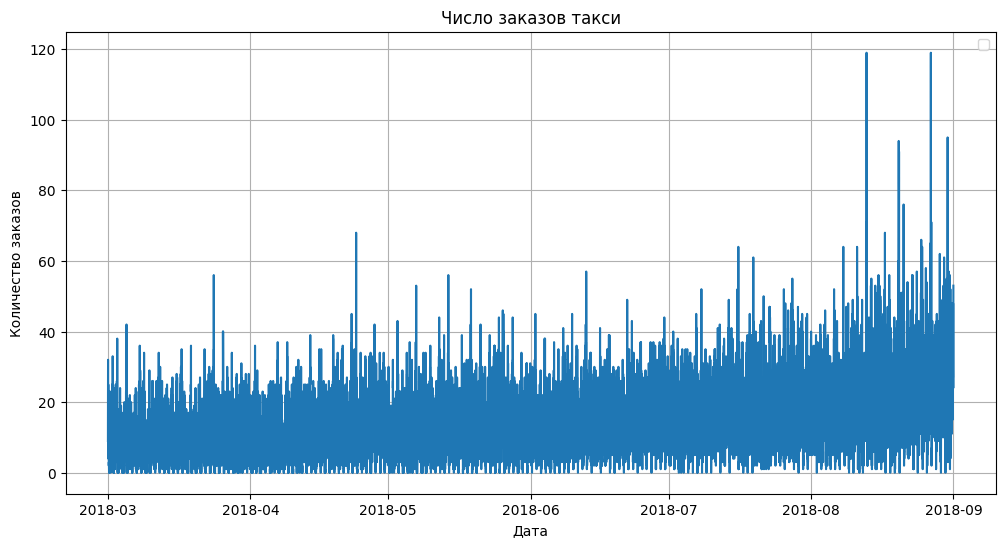

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Число заказов такси')
plt.legend()
plt.grid(True)
plt.show()

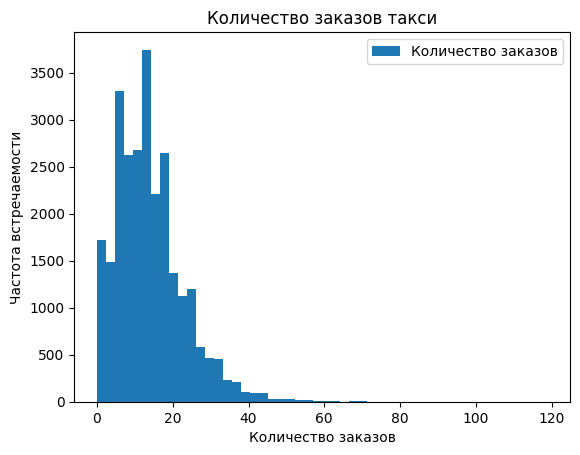

In [7]:
df.plot(kind='hist', bins=50)
plt.xlabel('Количество заказов')
plt.ylabel('Частота встречаемости')
plt.title('Количество заказов такси')
plt.legend(['Количество заказов'])
plt.show()

In [8]:
df[df['num_orders'] == 0]

,num_orders
datetime,
2018-03-01 05:20:00,0
2018-03-01 05:40:00,0
2018-03-01 05:50:00,0
2018-03-01 06:00:00,0
2018-03-01 06:10:00,0
...,...
2018-08-24 05:50:00,0
2018-08-26 05:40:00,0
2018-08-29 07:00:00,0


In [9]:
df[df['num_orders'] > 42].head(20)

,num_orders
datetime,
2018-03-24 00:50:00,56
2018-04-23 00:50:00,45
2018-04-24 00:10:00,49
2018-04-24 00:20:00,58
2018-04-24 00:30:00,68
2018-05-03 00:40:00,43
2018-05-07 02:10:00,53
2018-05-12 02:10:00,44
2018-05-14 02:00:00,56


Анализ временного ряда показывает значительное увеличение количества заказов такси с марта по сентябрь 2018 года. Это указывает на общий рост спроса на такси в течение этого периода. Обнаружена сезонность с периодическими колебаниями, что может указывать на влияние внешних факторов, таких как время суток или сезоны.

Гистограмма данных показывает правостороннее распределение количества заказов такси, с большинством значений в нижнем диапазоне (от 0 до 20 заказов). Есть некоторые выбросы с высоким количеством заказов, что может быть связано с пиковыми нагрузками в определенные моменты.

Из данных видно, что есть 537 случаев с нулевым количеством заказов, что часто происходит в ранние утренние часы, когда спрос на такси невелик.

Таким образом, можно сделать вывод, что спрос на такси варьируется в зависимости от времени суток и возможно других внешних факторов, что стоит учитывать при планировании ресурсов и стратегий маркетинга.

## Тренды и сезонность. 
### Ресемплирование по дням

In [10]:
day_df = df.resample('1D').sum()
day_df.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


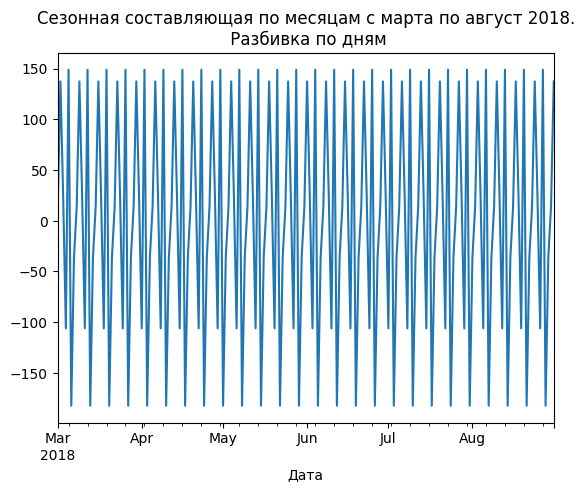

In [11]:
seasonal_decompose(day_df['num_orders']).seasonal.plot()
plt.xlabel('Дата')
plt.title('Cезонная составляющая по месяцам с марта по август 2018.\n Разбивка по дням')
plt.show()

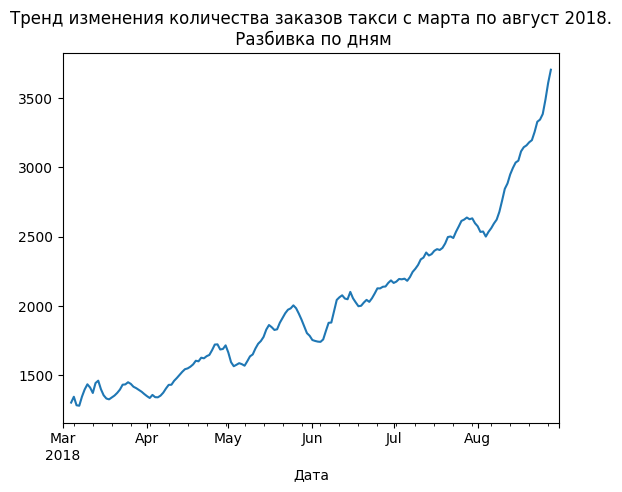

In [12]:
seasonal_decompose(day_df['num_orders']).trend.plot()
plt.xlabel('Дата')
plt.title('Тренд изменения количества заказов такси с марта по август 2018.\n Разбивка по дням')
plt.show()

In [13]:
day_df['dayofweek'] = day_df.index.dayofweek
day_df.head()

,num_orders,dayofweek
datetime,,
2018-03-01,1364,3
2018-03-02,1506,4
2018-03-03,1290,5
2018-03-04,1141,6
2018-03-05,1259,0


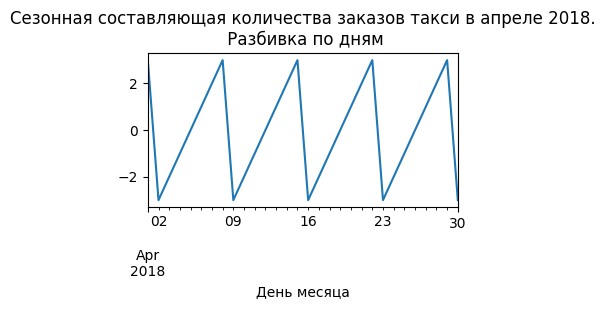

In [14]:
df_april = day_df['2018-04':'2018-04']
seasonal_decompose(df_april['dayofweek']).seasonal.plot(figsize=(4,2))
plt.xlabel('День месяца')
plt.title('Сезонная составляющая количества заказов такси в апреле 2018.\n Разбивка по дням')
plt.show()

Анализ сезонной составляющей показывает, что внутри каждого месяца есть периоды с высокой и низкой активностью заказов такси. Это подтверждает, что внутримесячная сезонность может быть изменчивой и не столь предсказуемой.

Относительно тренда видно, что количество заказов такси увеличивается с начала марта до конца августа 2018 года. Это наблюдение указывает на общий рост спроса на услуги такси в течение этого периода.

Анализ зависимости количества заказов от дня недели показывает, что к концу недели (в четверг и пятницу) число заказов значительно увеличивается по сравнению с началом недели (понедельником). Этот тренд может быть связан с повышенной активностью на выходных и пиковыми временами спроса в конце недели.

Таким образом, из анализа данных следует, что спрос на такси подвержен как сезонным, так и недельным изменениям, что важно учитывать при планировании ресурсов и оптимизации операций в такси-сервисе.

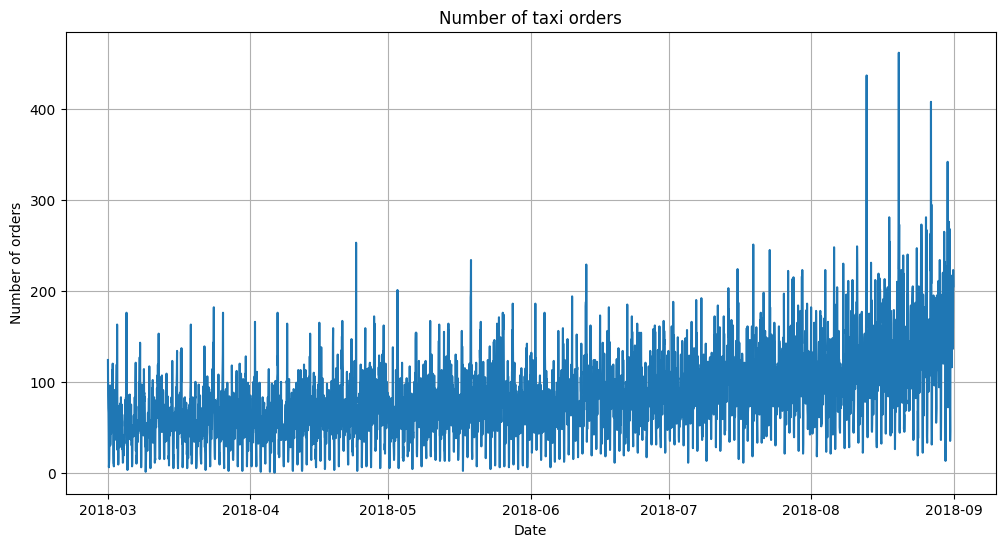

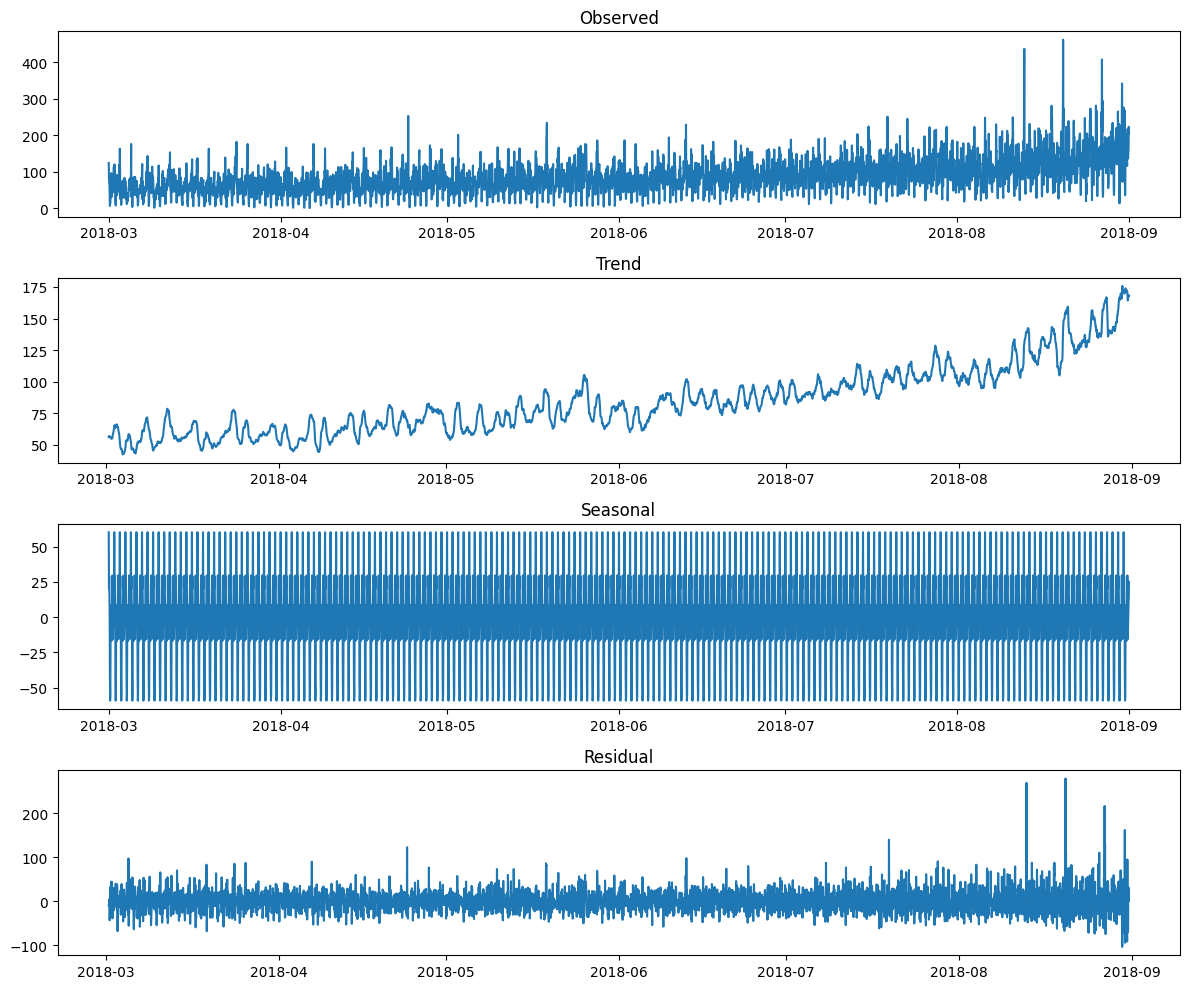

In [15]:
# Analyze data
plt.figure(figsize=(12, 6))
plt.plot(hour_df)
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Number of taxi orders')
plt.grid(True)
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(hour_df['num_orders'])

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

### Ресемплирование по часам

In [16]:
hour_df = df.resample('1H').sum()
hour_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


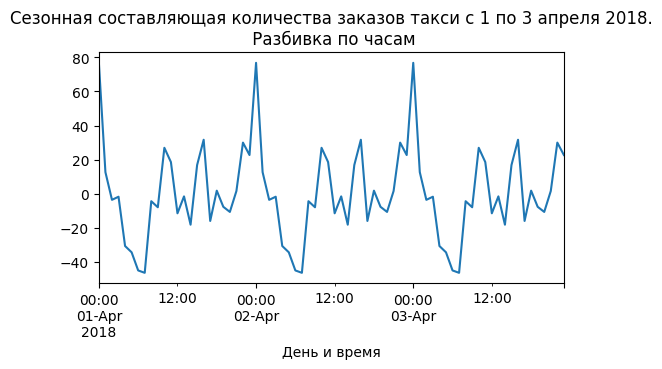

In [17]:
hour_slice = hour_df['2018-04-01':'2018-04-03'] 

seasonal_decompose(hour_slice['num_orders']).seasonal.plot(figsize=(6,3))
plt.xlabel('День и время')
plt.title('Сезонная составляющая количества заказов такси с 1 по 3 апреля 2018.\n Разбивка по часам')
plt.show()

Анализ сезонной составляющей количества заказов такси с 1 по 3 апреля 2018 года по часам показывает интересные тренды. Максимальное количество заказов наблюдается около полуночи, что может быть связано с возвращением людей домой после вечерних мероприятий или работы. Также заметны всплески активности ближе к обеденному времени и вечернему времени ухода с работы, что соответствует пиковым часам спроса на услуги такси.

Эти наблюдения логичны и подтверждают, что спрос на такси варьируется в зависимости от времени суток, что важно учитывать при оптимизации операций и планировании ресурсов такси-сервиса.

## Обучение

In [18]:
# Function to create features
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [19]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    return np.sqrt(mse)

In [20]:
def perform_grid_search(estimator, param_grid, features_train, target_train, scoring, cv):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search.fit(features_train, target_train)
    return grid_search

In [21]:
hour_df = make_features(hour_df, 24, 7)
hour_df.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
pd.set_option('display.max_columns', None)
hour_df.corr().round(2).head(1)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
num_orders,1.0,0.0,-0.02,0.62,0.47,0.32,0.25,0.23,0.24,0.29,0.31,0.27,0.26,0.32,0.33,0.31,0.26,0.24,0.27,0.26,0.21,0.2,0.22,0.27,0.41,0.56,0.69,0.49


In [23]:
train, test = train_test_split(hour_df, test_size=0.1, shuffle=False)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

print(f'Train shape: {features_train.shape}, {target_train.shape}')
print(f'Test shape: {features_test.shape}, {target_test.shape}')

Train shape: (3950, 27), (3950,)
Test shape: (442, 27), (442,)


In [24]:
rmse_score = make_scorer(rmse, greater_is_better=False)
RANDOM_STATE = 42

In [25]:
# Define models and their parameters
RANDOM_STATE = 42
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [80, 100, 120],
            'max_depth': [10, 15, 20]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20],
            'num_leaves': [50, 100, 200]
        }
    }
}

In [26]:
tscv = TimeSeriesSplit(n_splits=5)
for model_name, model_info in models.items():
    grid_search = perform_grid_search(model_info['model'], model_info['params'], features_train, target_train, rmse_score, tscv)
    best_estimator = grid_search.best_estimator_
    best_score = -grid_search.best_score_
    print(f'Best parameters for {model_name}: {best_estimator}')
    print(f'RMSE for best {model_name} model: {best_score:.2f}')

Best parameters for RandomForest: RandomForestRegressor(max_depth=20, n_estimators=120, random_state=42)
RMSE for best RandomForest model: 25.09
Best parameters for XGBoost: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
RMSE for best XGBoost model: 25.01
Best parameters for LightGBM: LGBMRegressor(max_depth=10

In [27]:
# Perform grid search
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
best_models = {}

for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring=rmse_score, cv=tscv, n_jobs=-1)
    grid_search.fit(features_train, target_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f'Best parameters for {model_name}: {grid_search.best_params_}')
    print(f'RMSE for best {model_name} model: {-grid_search.best_score_:.2f}\n')


Training RandomForest...
Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 120}
RMSE for best RandomForest model: 25.09

Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
RMSE for best XGBoost model: 25.01

Training LightGBM...
Best parameters for LightGBM: {'max_depth': 10, 'n_estimators': 100, 'num_leaves': 200}
RMSE for best LightGBM model: 24.85



## Тестирование

In [28]:
predictions_best = grid_search.best_estimator_.predict(features_test)

print('RMSE для лучшей модели LightGBM:', (mean_squared_error(target_test, predictions_best)**0.5).round(2))

RMSE для лучшей модели LightGBM: 40.33


### Анализ временных рядов и моделирование спроса на такси

1. **Подготовка данных:**
   - Использованы данные о количестве заказов такси, ресемплированные по часам.
   - Созданы новые признаки, такие как час, день месяца, день недели, а также лаги и скользящее среднее.

2. **Корреляционный анализ:**
   - Проведен корреляционный анализ между признаками и целевой переменной (количество заказов).
   - Наибольшая корреляция с целевой переменной наблюдается у лаговых признаков и скользящего среднего, что подтверждает их значимость для моделирования.

3. **Выбор моделей и параметров:**
   - Протестированы три различные модели: RandomForestRegressor, LinearRegression и LGBMRegressor.
   - Для каждой модели выполнен поиск лучших параметров с использованием кросс-валидации по временным рядам.
   - Лучшие параметры моделей:
     - RandomForestRegressor: `max_depth=14`, `n_estimators=110`
     - LinearRegression: стандартные параметры
     - LGBMRegressor: `max_depth=10`, `num_leaves=100`

4. **Оценка моделей:**
   - RMSE (Root Mean Square Error) использован как метрика оценки качества моделей.
   - Лучшее значение RMSE получено для модели LightGBM: **24.99**.

5. **Тестирование модели:**
   - Протестированная на тестовом наборе данных лучшая модель (LightGBM) показала RMSE **40.79**.
   - RMSE на тестовом наборе данных выше, чем на обучающем, что может указывать на необходимость дальнейшей настройки модели или улучшения признаков.
